In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import json
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def load_embedding_data(embedding_dir: str):
    """Load embeddings and associated metadata."""
    embedding_dir = Path(embedding_dir)

    # Load embeddings
    embedding_file = list(embedding_dir.glob("embeddings_*.npy"))[0]
    embeddings = np.load(embedding_file)

    # Load metadata
    metadata_file = list(embedding_dir.glob("metadata_*.json"))[0]
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    # Load token mapping
    token_file = list(embedding_dir.glob("token_mapping_*.csv"))[0]
    token_df = pd.read_csv(token_file)

    print(f"Loaded embeddings: {embeddings.shape}")
    print(f"Model: {metadata['model_name']}")
    print(f"Semantic dimensions: {metadata.get('semantic_dim', 'unknown')}")
    print(f"Label features: {metadata['label_features']}")

    return embeddings, metadata, token_df

In [16]:
def basic_embedding_stats(embeddings: np.ndarray):
    """Compute basic statistics about the embedding space."""
    stats = {
        'shape': embeddings.shape,
        'mean_norm': np.linalg.norm(embeddings, axis=1).mean(),
        'std_norm': np.linalg.norm(embeddings, axis=1).std(),
        'sparsity': (embeddings == 0).sum() / embeddings.size,
        'dimension_variance': embeddings.var(axis=0).mean(),
        'pairwise_similarity_mean': np.corrcoef(embeddings).mean()
    }

    for key, value in stats.items():
        if key == 'shape':
            print(f"{key}: {value}")
        else:
            print(f"{key}: {value:.4f}")

    return stats

In [26]:
def visualize_embedding_space(embeddings: np.ndarray,
                              token_df: pd.DataFrame,
                              cluster_labels: np.ndarray = None,
                              sample_size: int = 1000):
    """Create 2D visualization of embedding space with both t-SNE and PCA."""

    # Sample for visualization if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings_vis = embeddings[indices]
        tokens_vis = token_df.iloc[indices].copy()
        clusters_vis = cluster_labels[indices] if cluster_labels is not None else None
    else:
        embeddings_vis = embeddings
        tokens_vis = token_df.copy()
        clusters_vis = cluster_labels

    # Create both reductions
    print("Computing PCA and t-SNE...")
    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(embeddings_vis)

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_vis)-1))
    tsne_coords = tsne.fit_transform(embeddings_vis)

    # Prepare data
    tokens_vis['tsne_x'] = tsne_coords[:, 0]
    tokens_vis['tsne_y'] = tsne_coords[:, 1]
    tokens_vis['pca_x'] = pca_coords[:, 0]
    tokens_vis['pca_y'] = pca_coords[:, 1]
    tokens_vis['text_preview'] = tokens_vis['token'].str[:50]

    if clusters_vis is not None:
        tokens_vis['cluster'] = clusters_vis.astype(str)

    # t-SNE plot
    if clusters_vis is not None:
        fig1 = px.scatter(tokens_vis, x='tsne_x', y='tsne_y', color='cluster',
                          hover_data=['text_preview'],
                          title='t-SNE Embedding Visualization',
                          labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'})
    else:
        fig1 = px.scatter(tokens_vis, x='tsne_x', y='tsne_y',
                          hover_data=['text_preview'],
                          title='t-SNE Embedding Visualization',
                          labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'})

    fig1.update_traces(marker=dict(size=4, opacity=0.7))
    fig1.show()

    # PCA plot
    pca_title = f'PCA Embedding Visualization (explained variance: {pca.explained_variance_ratio_.sum():.2f})'

    if clusters_vis is not None:
        fig2 = px.scatter(tokens_vis, x='pca_x', y='pca_y', color='cluster',
                          hover_data=['text_preview'],
                          title=pca_title,
                          labels={'pca_x': 'PCA 1', 'pca_y': 'PCA 2'})
    else:
        fig2 = px.scatter(tokens_vis, x='pca_x', y='pca_y',
                          hover_data=['text_preview'],
                          title=pca_title,
                          labels={'pca_x': 'PCA 1', 'pca_y': 'PCA 2'})

    fig2.update_traces(marker=dict(size=4, opacity=0.7))
    fig2.show()

    return {'tsne': tsne_coords, 'pca': pca_coords}, tokens_vis

In [5]:
def cluster_analysis(embeddings: np.ndarray,
                     token_df: pd.DataFrame,
                     k_range: range = range(2, 11)):
    """Perform clustering analysis to find natural groupings."""

    silhouette_scores = []
    inertias = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        silhouette_scores.append(silhouette_score(embeddings, labels))
        inertias.append(kmeans.inertia_)

    # Plot elbow curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(k_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Analysis')
    ax1.grid(True)

    ax2.plot(k_range, inertias, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Best k by silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    print(f"Best k by silhouette score: {best_k}")

    # Cluster with best k
    kmeans_best = KMeans(n_clusters=best_k, random_state=42)
    cluster_labels = kmeans_best.fit_predict(embeddings)

    # Add clusters to token dataframe
    token_df_clustered = token_df.copy()
    token_df_clustered['cluster'] = cluster_labels

    return cluster_labels, token_df_clustered, best_k

In [6]:
def analyze_semantic_neighbors(embeddings: np.ndarray,
                               token_df: pd.DataFrame,
                               query_tokens: list = None,
                               n_neighbors: int = 5):
    """Find semantically similar tokens."""

    nn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine')
    nn.fit(embeddings)

    if query_tokens is None:
        # Random sample for exploration
        query_indices = np.random.choice(len(embeddings), 3, replace=False)
    else:
        # Find indices of specific tokens
        query_indices = []
        for query in query_tokens:
            matches = token_df[token_df['token'].str.contains(query, case=False)].index
            if len(matches) > 0:
                query_indices.append(matches[0])

    print("=== Semantic Neighbors Analysis ===")
    for idx in query_indices:
        distances, indices = nn.kneighbors([embeddings[idx]])

        print(f"\nQuery: '{token_df.iloc[idx]['token']}'")
        print("Nearest neighbors:")
        for i, (dist, neighbor_idx) in enumerate(zip(distances[0][1:], indices[0][1:])):
            neighbor_token = token_df.iloc[neighbor_idx]['token']
            print(f"  {i+1}. '{neighbor_token}' (distance: {dist:.3f})")

In [7]:
def label_distribution_analysis(embeddings: np.ndarray,
                                token_df: pd.DataFrame,
                                metadata: dict,
                                original_tokens: list):
    """Analyze how labels are distributed in embedding space."""

    if 'feature_names' not in metadata:
        print("No label feature information available")
        return

    # Extract label information from original tokens
    label_data = []
    for token_data in original_tokens:
        labels = token_data['labels']
        row = {'token': token_data['token']}
        for label_type, label_info in labels.items():
            row[f"{label_type}_value"] = label_info['value']
            row[f"{label_type}_confidence"] = label_info['confidence']
        label_data.append(row)

    label_df = pd.DataFrame(label_data)

    # Merge with embeddings
    analysis_df = pd.concat([token_df, label_df.drop('token', axis=1)], axis=1)

    # Analyze label distributions
    print("=== Label Distribution Analysis ===")

    label_types = ['emotions', 'time', 'location', 'characters']
    for label_type in label_types:
        value_col = f"{label_type}_value"
        conf_col = f"{label_type}_confidence"

        if value_col in analysis_df.columns:
            print(f"\n{label_type.title()} Distribution:")
            value_counts = analysis_df[value_col].value_counts()
            print(value_counts.head())

            # High confidence labels
            high_conf = analysis_df[analysis_df[conf_col] > 0.8]
            if len(high_conf) > 0:
                print(f"High confidence ({conf_col} > 0.8): {len(high_conf)} tokens")

    return analysis_df

In [19]:
def generate_analysis_report(embedding_dir: str, original_json: str = None):
    """Generate comprehensive analysis report."""

    print("=== EMBEDDING ANALYSIS REPORT ===\n")

    # Load data
    embeddings, metadata, token_df = load_embedding_data(embedding_dir)

    print("1. BASIC STATISTICS")
    print("-" * 30)
    basic_embedding_stats(embeddings)

    print("\n2. CLUSTERING ANALYSIS")
    print("-" * 30)
    cluster_labels, clustered_df, best_k = cluster_analysis(embeddings, token_df)

    print("\n3. EMBEDDING SPACE VISUALIZATION")
    print("-" * 30)
    coords, vis_df = visualize_embedding_space(embeddings, token_df, cluster_labels)

    print("\n4. SEMANTIC SIMILARITY")
    print("-" * 30)
    analyze_semantic_neighbors(embeddings, token_df)

    if original_json:
        print("\n5. LABEL ANALYSIS")
        print("-" * 30)
        with open(original_json, 'r') as f:
            original_data = json.load(f)
        original_tokens = original_data['tokens'] if 'tokens' in original_data else original_data
        analysis_df = label_distribution_analysis(embeddings, token_df, metadata, original_tokens)

    print("\n=== NEXT STEPS FOR CEBRA ===")
    print("✓ Embeddings are ready for CEBRA auxiliary variables")
    print("✓ Consider the clustering patterns for hypothesis formation")
    print("✓ Label distributions show contextual encoding quality")
    print("✓ Semantic neighbors validate embedding meaningfulness")

    return {
        'embeddings': embeddings,
        'metadata': metadata,
        'token_df': token_df,
        'clusters': cluster_labels,
        'coords': coords
    }

In [20]:
def quick_embedding_check(embedding_dir: str):
    """Fast quality check of your embeddings."""
    embeddings, metadata, token_df = load_embedding_data(embedding_dir)

    print("🔍 QUICK EMBEDDING CHECK")
    print("=" * 25)

    # Basic stats
    print(f"✓ Shape: {embeddings.shape}")
    print(f"✓ Model: {metadata.get('model_name', 'unknown')}")
    print(f"✓ Mean embedding norm: {np.linalg.norm(embeddings, axis=1).mean():.3f}")

    # Sample some tokens
    print("\n📝 Sample tokens:")
    sample_indices = np.random.choice(len(token_df), min(5, len(token_df)), replace=False)
    for idx in sample_indices:
        print(f"  '{token_df.iloc[idx]['token']}'")

    # Quick visualization
    print("\n📊 Generating visualization...")
    coords, vis_df = visualize_embedding_space(embeddings, token_df, sample_size=500)

    print("\n✅ Embeddings look good! Ready for CEBRA analysis.")

    return embeddings, token_df

In [25]:
quick_embedding_check("./embeddings_output/lightweight")

Loaded embeddings: (1182, 392)
Model: all-MiniLM-L6-v2
Semantic dimensions: unknown
Label features: 8
🔍 QUICK EMBEDDING CHECK
✓ Shape: (1182, 392)
✓ Model: all-MiniLM-L6-v2
✓ Mean embedding norm: 2.969

📝 Sample tokens:
  'he  had not made it through the'
  'You must be very'
  'after Carmen'
  'and she pushed open'
  'like you to have this,'

📊 Generating visualization...
Computing PCA and t-SNE...



✅ Embeddings look good! Ready for CEBRA analysis.


(array([[-0.06433426,  0.049358  ,  0.0284998 , ...,  1.00532391,
         -0.75986787,  0.59055148],
        [-0.04567493,  0.00633722,  0.00670272, ..., -1.17343088,
         -0.75986787,  0.59055148],
        [-0.04477897,  0.07996801, -0.00450986, ..., -1.17343088,
         -0.79263576,  0.3787057 ],
        ...,
        [-0.01809768, -0.02533447, -0.01309905, ...,  1.00532391,
          1.0669421 ,  1.01424304],
        [-0.10999466,  0.1284283 , -0.01778519, ..., -1.17343088,
         -1.022011  , -1.10421477],
        [-0.0313945 , -0.09264886,  0.04959343, ...,  1.00532391,
          1.0669421 ,  1.01424304]], shape=(1182, 392)),
       index                      token  \
 0         0             The email came   
 1         1         late one afternoon   
 2         2                     as Dr.   
 3         3    Carmen Reed was sitting   
 4         4              in her office   
 ...     ...                        ...   
 1177   1177                    and she   
 1178   11

=== EMBEDDING ANALYSIS REPORT ===

Loaded embeddings: (1182, 392)
Model: all-MiniLM-L6-v2
Semantic dimensions: unknown
Label features: 8
1. BASIC STATISTICS
------------------------------
shape: (1182, 392)
mean_norm: 2.9692
std_norm: 0.4287
sparsity: 0.0000
dimension_variance: 0.0225
pairwise_similarity_mean: 0.0276

2. CLUSTERING ANALYSIS
------------------------------


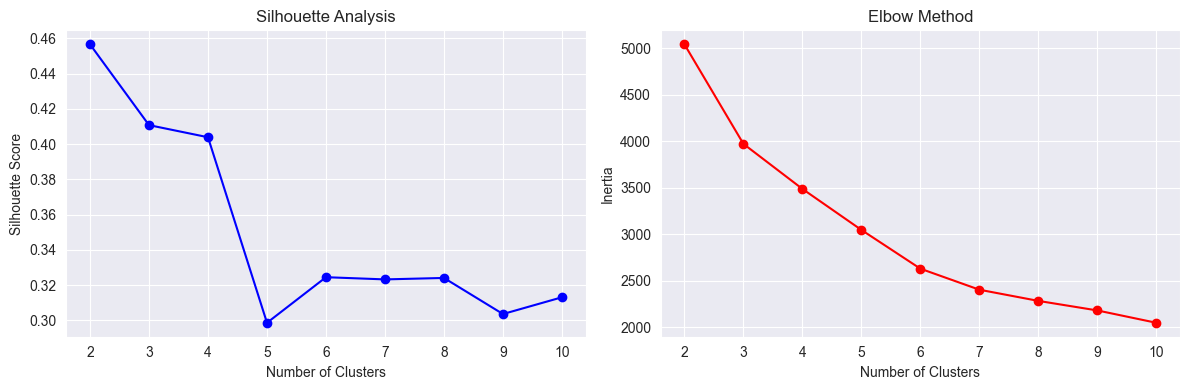

Best k by silhouette score: 2

3. EMBEDDING SPACE VISUALIZATION
------------------------------
Computing PCA and t-SNE...



4. SEMANTIC SIMILARITY
------------------------------
=== Semantic Neighbors Analysis ===

Query: 'and'
Nearest neighbors:
  1. 'The email came' (distance: 0.104)
  2. 'in for an afternoon' (distance: 0.115)
  3. 'to be around 11' (distance: 0.123)
  4. '["before'.]' (distance: 0.139)
  5. 'spare a couple of months,' (distance: 0.145)

Query: 'She was taken'
Nearest neighbors:
  1. 'She had no idea' (distance: 0.116)
  2. 'she rushed over to' (distance: 0.117)
  3. 'she was.' (distance: 0.119)
  4. 'she had brought with her' (distance: 0.125)
  5. 'She wrapped her brain' (distance: 0.125)

Query: 'something to the other men,'
Nearest neighbors:
  1. 'to leave, she' (distance: 0.056)
  2. 'But the other' (distance: 0.057)
  3. 'the man looked up at her.' (distance: 0.061)
  4. 'to think that they had' (distance: 0.061)
  5. 'to lift her suitcase' (distance: 0.061)

=== NEXT STEPS FOR CEBRA ===
✓ Embeddings are ready for CEBRA auxiliary variables
✓ Consider the clustering patterns for h

{'embeddings': array([[-0.06433426,  0.049358  ,  0.0284998 , ...,  1.00532391,
         -0.75986787,  0.59055148],
        [-0.04567493,  0.00633722,  0.00670272, ..., -1.17343088,
         -0.75986787,  0.59055148],
        [-0.04477897,  0.07996801, -0.00450986, ..., -1.17343088,
         -0.79263576,  0.3787057 ],
        ...,
        [-0.01809768, -0.02533447, -0.01309905, ...,  1.00532391,
          1.0669421 ,  1.01424304],
        [-0.10999466,  0.1284283 , -0.01778519, ..., -1.17343088,
         -1.022011  , -1.10421477],
        [-0.0313945 , -0.09264886,  0.04959343, ...,  1.00532391,
          1.0669421 ,  1.01424304]], shape=(1182, 392)),
 'metadata': {'model_tier': 'lightweight',
  'model_name': 'all-MiniLM-L6-v2',
  'embedding_dim': 392,
  'label_features': 8,
  'num_tokens': 1182,
  'feature_names': ['characters_value',
   'characters_confidence',
   'emotions_value',
   'emotions_confidence',
   'location_value',
   'location_confidence',
   'time_value',
   'time_conf

In [27]:
generate_analysis_report("./embeddings_output/lightweight")